In [19]:
# Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F  # Make sure this import is here

In [21]:
# COCO Dataset for lat and lon only
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        data_points = 4  # Number of data points in each class (x, y, h, w)
        lat_lon = 2 # Adding 2 to the size for the lat lon for the image
        input_size = num_classes * max_instances_per_class * data_points + lat_lon  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_lat = image_info['cheap_latitude']
            image_lon = image_info['cheap_longitude']
            
            # Extract the expensive GPS data as the target output
            expensive_latitude = float(image_info['expensive_latitude'])
            expensive_longitude = float(image_info['expensive_longitude'])
            # Ensure that only latitude and longitude are included
            geolocation = [expensive_latitude, expensive_longitude]
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            input_vector[len(input_vector) - 2] = image_lat
            input_vector[len(input_vector) - 1] = image_lon

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)  # Only latitude and longitude are appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)  # This should now be of shape [2]
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path

In [23]:
# COCO Dataset for lat and lon only
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        data_points = 4  # Number of data points in each class (x, y, h, w)
        lat_lon = 2 # Adding 2 to the size for the lat lon for the image
        input_size = num_classes * max_instances_per_class * data_points + lat_lon  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_lat = float(image_info['cheap_latitude'])
            image_lon = float(image_info['cheap_longitude'])
            
            # Extract the expensive GPS data as the target output
            expensive_latitude = float(image_info['expensive_latitude'])
            expensive_longitude = float(image_info['expensive_longitude'])
            # Ensure that only latitude and longitude are included
            geolocation = [expensive_latitude, expensive_longitude]
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            input_vector[len(input_vector) - 2] = image_lat
            input_vector[len(input_vector) - 1] = image_lon

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)  # Only latitude and longitude are appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)  # This should now be of shape [2]
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path

In [25]:
# FFNN Arch.
class LatLonModel(nn.Module):
    def __init__(self):
        super(LatLonModel, self).__init__()
        self.fc1 = nn.Linear(74, 40)  # Single hidden layer with 40 neurons
        self.bn1 = nn.BatchNorm1d(40)  # Batch normalization
        self.fc2 = nn.Linear(40, 2)    # Output layer (latitude and longitude)
        self.dropout = nn.Dropout(p=0.3)  # DropoutRuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
        x = self.dropout(x)  # Apply dropout before the final output layer
        x = self.fc2(x)  # Output layer
        return x


In [27]:
# Load the COCO JSON data
coco_file_path = 'Test_4/Filtered_Lat_Lon_2BBox_Each_Class_Annotation.json'  
images_dir = 'Test_4/captured_images_test4' 

# Create the dataset for latitude and longitude
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)
print(lat_lon_dataset[0][0])
print(f"Example bounding box for Lat/Lon: {lat_lon_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size
lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])

# Create dataloaders
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=10, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=10, shuffle=False)

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000, 820.7961,  40.0580, 428.2375, 311.7699,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,  35.7707, -78.6743])
Example bounding box for Lat/Lon: torch.Size([74])


In [29]:
# Initialize LatLonModel
lat_lon_model = LatLonModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lat_lon_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop for LatLonModel
num_epochs = 100

for epoch in range(num_epochs):
    lat_lon_model.train()
    for inputs, targets, _ in lat_lon_train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass through the lat_lon_model
        outputs = lat_lon_model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Lat/Lon Loss: {loss.item():.8f}')
    
# Save the trained LatLonModel
lat_lon_model_save_path = "lat_lon_model_gps.pt"
torch.save(lat_lon_model.state_dict(), lat_lon_model_save_path)
print("Lat/Lon model training completed!")


Epoch [1/100], Lat/Lon Loss: 36.28074646
Epoch [2/100], Lat/Lon Loss: 18.86596870
Epoch [3/100], Lat/Lon Loss: 25.59274673
Epoch [4/100], Lat/Lon Loss: 46.62900162
Epoch [5/100], Lat/Lon Loss: 40.62527847
Epoch [6/100], Lat/Lon Loss: 6.72292089
Epoch [7/100], Lat/Lon Loss: 37.76797867
Epoch [8/100], Lat/Lon Loss: 16.39589691
Epoch [9/100], Lat/Lon Loss: 15.20572567
Epoch [10/100], Lat/Lon Loss: 12.40623665
Epoch [11/100], Lat/Lon Loss: 8.69030094
Epoch [12/100], Lat/Lon Loss: 8.13763905
Epoch [13/100], Lat/Lon Loss: 9.30263233
Epoch [14/100], Lat/Lon Loss: 8.49533653
Epoch [15/100], Lat/Lon Loss: 6.58828878
Epoch [16/100], Lat/Lon Loss: 3.15987110
Epoch [17/100], Lat/Lon Loss: 0.98588032
Epoch [18/100], Lat/Lon Loss: 4.94950342
Epoch [19/100], Lat/Lon Loss: 2.53012514
Epoch [20/100], Lat/Lon Loss: 6.23169279
Epoch [21/100], Lat/Lon Loss: 4.47941780
Epoch [22/100], Lat/Lon Loss: 3.48675323
Epoch [23/100], Lat/Lon Loss: 1.39570153
Epoch [24/100], Lat/Lon Loss: 0.90595788
Epoch [25/100], 

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from PIL import Image
import random

# Assuming you have already defined COCOGeolocationDataset and LatLonModel

# Load pre-trained LatLonModel
lat_lon_model = LatLonModel()
lat_lon_model.load_state_dict(torch.load("lat_lon_model_gps.pt", weights_only=True))
lat_lon_model.eval()  # Set the model to evaluation mode

# Create the dataset and split it
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size

lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=10, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=10, shuffle=False)

# Evaluate the LatLonModel on the test set
all_predictions = []
all_targets = []
image_paths = []

with torch.no_grad():
    for inputs, targets, paths in lat_lon_test_dataloader:
        outputs = lat_lon_model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)

# Combine all predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error
criterion = nn.MSELoss()
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set: {mse:.8f}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.8f}')

# Function to visualize random test images with bounding boxes and geolocation labels
def visualize_random_predictions(test_dataset, all_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_output = all_predictions[i].cpu().numpy()
        
        # Latitude and longitude
        predicted_lat_lon = predicted_output[:2]
        actual_lat_lon = geolocation[:2].numpy()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Adjust this number based on your dataset
        max_instances_per_class = 2
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display geolocations with clear labels (latitude and longitude)
        plt.text(10, 20, f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})")
        print(f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})")
        
        plt.title('Random Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the test set
visualize_random_predictions(lat_lon_test_dataset, all_predictions, num_images=10)


Mean Squared Error on Compass Test Set: 7316.79638672
Root Mean Squared Error (RMSE) on Compass Test Set: 85.53827440
Actual Compass: 279.39822388
Predicted Compass: 75.38256073


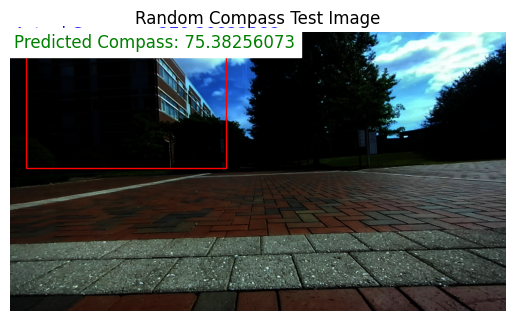

Actual Compass: 217.13531494
Predicted Compass: 211.69061279


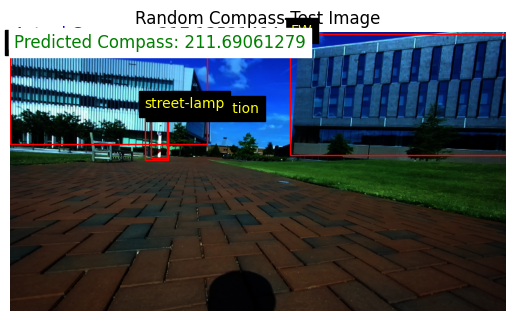

Actual Compass: 215.66200256
Predicted Compass: 210.11170959


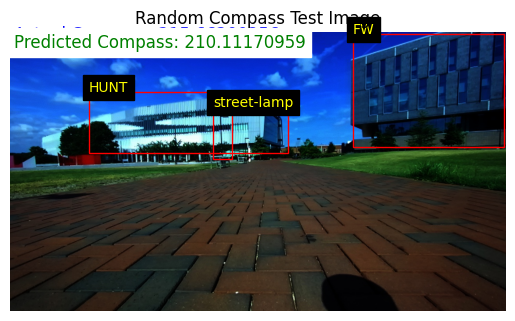

Actual Compass: 30.99238205
Predicted Compass: 89.42601776


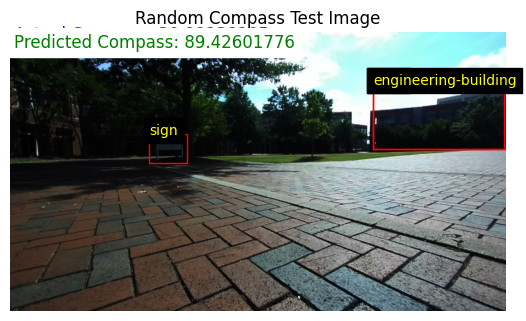

Actual Compass: 211.43742371
Predicted Compass: 112.36466980


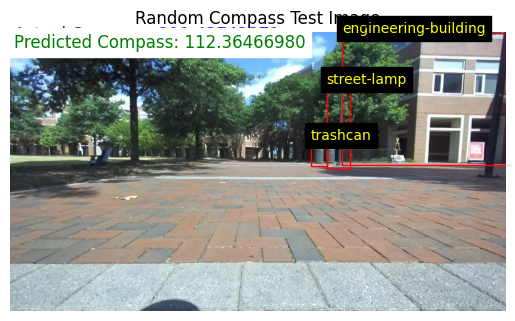

Actual Compass: 33.10834503
Predicted Compass: 115.54086304


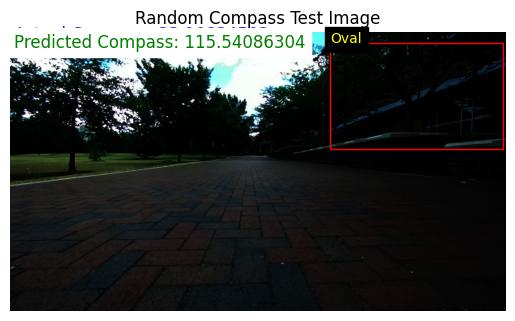

In [ ]:
# Result of compass model
import random
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the compass model on the test set
compass_model.eval()
compass_predictions = []
compass_targets = []
compass_image_paths = []

# Use compass_test_dataloader for evaluation
with torch.no_grad():
    for inputs, targets, paths in compass_test_dataloader:
        outputs = compass_model(inputs)
        compass_predictions.append(outputs)
        compass_targets.append(targets)
        compass_image_paths.extend(paths)

# Combine all predictions and targets for compass orientation
compass_predictions = torch.cat(compass_predictions, dim=0)
compass_targets = torch.cat(compass_targets, dim=0)

# Calculate Mean Squared Error for compass orientation
compass_mse = criterion(compass_predictions, compass_targets).item()
print(f'Mean Squared Error on Compass Test Set: {compass_mse:.8f}')

compass_rmse = math.sqrt(compass_mse)
print(f'Root Mean Squared Error (RMSE) on Compass Test Set: {compass_rmse:.8f}')

# Function to visualize random test images with compass orientation labels
def visualize_random_compass_predictions(test_dataset, compass_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_orientation = compass_predictions[i].cpu().numpy()[0]
        actual_orientation = geolocation[0].item()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display compass orientation with clear labels
        plt.text(10, 20, f"Actual Compass: {actual_orientation:.8f}", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Compass: {predicted_orientation:.8f}", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Compass: {actual_orientation:.8f}")
        print(f"Predicted Compass: {predicted_orientation:.8f}")
        
        plt.title('Random Compass Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the compass test set
visualize_random_compass_predictions(compass_test_dataset, compass_predictions, num_images=10)
